생성적 적대 신경망(GAN, Generateive Adversarial Networks) : Generator와 Discriminator을 이용해 이미지 생성

##### 가짜 제조 공장, 생성자

생성자(Generator) : 가상의 이미지 제작

DCGAN(Deep Convolution GAN) : goole AI팀에서 만든 CNN에 GAN을 적용한 알고리즘

배치 정규화(Batch Normalization) : 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치

##### 진위를 가려내는 장치, 판별자

판별자(discriminator) : 생성자에서 만들어진 이미지의 진위여부를 가려내는 알고리즘


##### 적대적 신경망 실행하기

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델 만들기
generator = Sequential()
generator.add(Dense(128 * 7 * 7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28, 28, 1), padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = 'adam')

discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan모델 만들기
ginput = Input(shape = (100, ))

dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy',
            optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [7]:
import os

os.mkdir('gan_images')

11501568/11490434 [==============================] - 0s 0us/step
epoch : 0, d_loss :  0.7323, g_loss :  0.4090
epoch : 1, d_loss :  0.5043, g_loss :  0.1566
epoch : 2, d_loss :  0.4465, g_loss :  0.0520
epoch : 3, d_loss :  0.4635, g_loss :  0.0260
epoch : 4, d_loss :  0.4655, g_loss :  0.0300
epoch : 5, d_loss :  0.4745, g_loss :  0.0663
epoch : 6, d_loss :  0.4502, g_loss :  0.1712
epoch : 7, d_loss :  0.4343, g_loss :  0.3503
epoch : 8, d_loss :  0.4675, g_loss :  0.4186
epoch : 9, d_loss :  0.4683, g_loss :  0.4501
epoch : 10, d_loss :  0.4729, g_loss :  0.4295
epoch : 11, d_loss :  0.4358, g_loss :  0.4713
epoch : 12, d_loss :  0.4230, g_loss :  0.5626
epoch : 13, d_loss :  0.4152, g_loss :  0.6942
epoch : 14, d_loss :  0.4651, g_loss :  0.7304
epoch : 15, d_loss :  0.5381, g_loss :  0.5096
epoch : 16, d_loss :  0.4396, g_loss :  0.2558
epoch : 17, d_loss :  0.3140, g_loss :  0.1591
epoch : 18, d_loss :  0.2248, g_loss :  0.1053
epoch : 19, d_loss :  0.1477, g_loss :  0.0657
epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


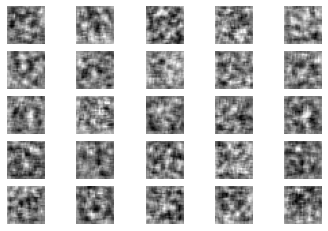

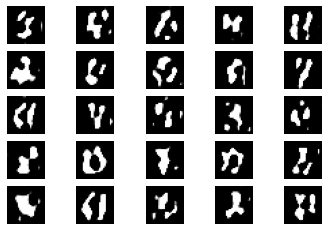

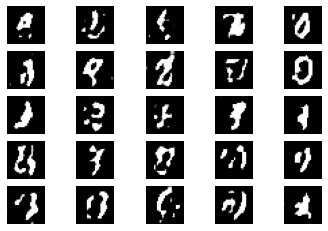

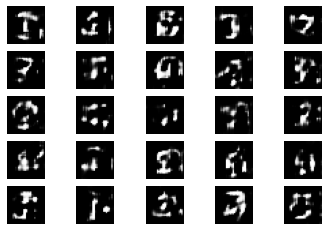

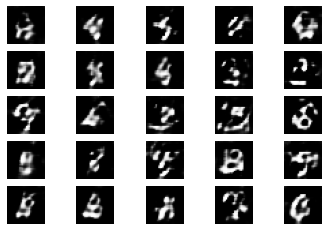

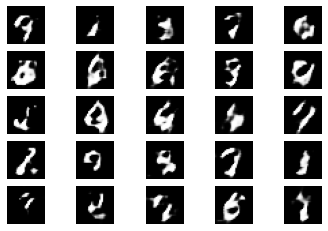

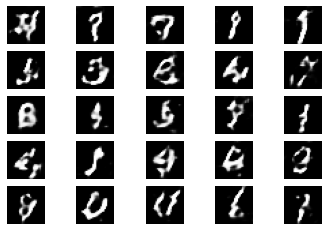

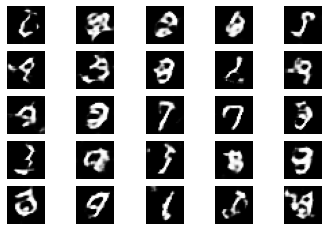

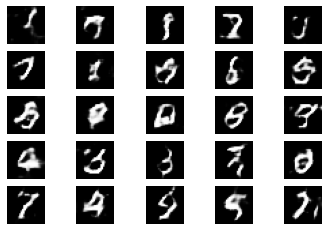

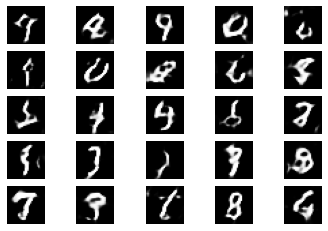

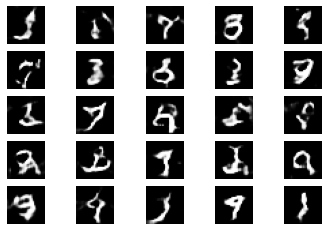

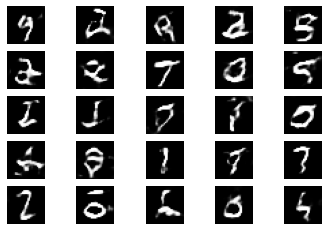

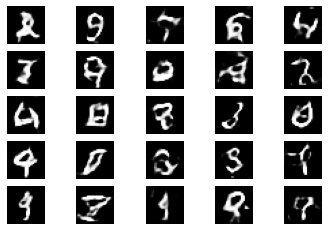

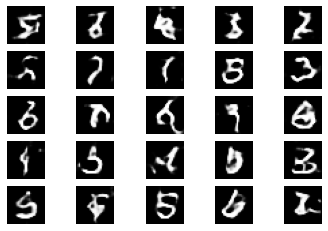

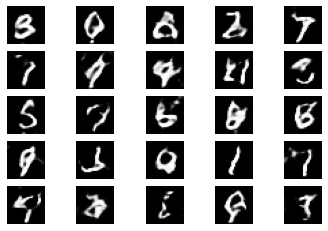

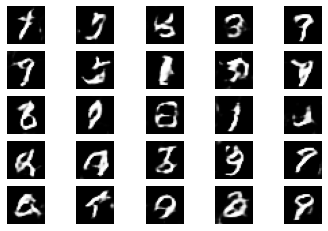

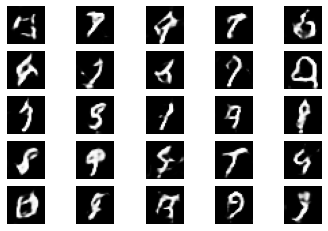

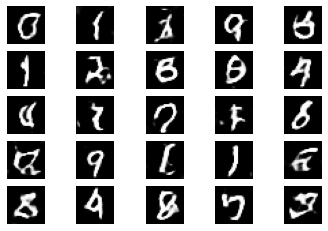

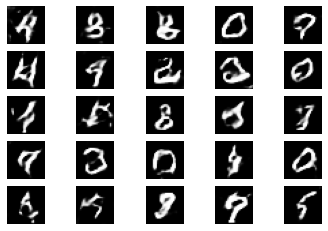

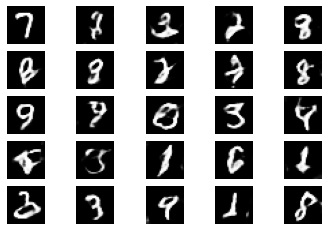

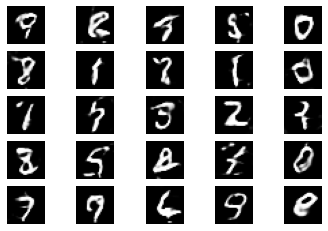

In [3]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):

    # MNIST 데이터 불러오기
    # 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요 없고, 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # 127.5를 뺴준 뒤 127.5로 나눠서 -1 ~ 1 사이의 값으로 바꿈
    X_train = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print(f'epoch : {i}, d_loss : {d_loss : .4f}, g_loss : {g_loss : .4f}')

        # 중간 과정을 이미지로 저장하는 부분, 정해진 인터벌 만큼 학습되면 그때 만든 이미지를 gan_images폴더에 저장하라는 뜻

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig(f'gan_images/gan_mnist_{i}.png')

# 4,000번 반복되고(+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)

##### 이미지의 특징을 추출하는 오토 인코더

오토인코더(AE, Auto-Encoder) : Gan이 가상의 이미지를 생성한다면 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어냄, 영상의학 분야 등 데이터는 적은 분야에서 사용하며, GAN을 이용하면 가상의 것을 넣기 때문에 예상치 못한 결과를 가져올 수 있음

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터 셋을 호출
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255.

# 생성자 모델 만들기
autoencoder = Sequential()

# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size = 3, padding = 'same', input_shape = (28, 28, 1), activation = 'relu'))
autoencoder.add(MaxPooling2D(pool_size = 2, padding = 'same'))
autoencoder.add(Conv2D(8, kernel_size = 3, activation = 'relu', padding = 'same'))
autoencoder.add(MaxPooling2D(pool_size = 2, padding = 'same'))
autoencoder.add(Conv2D(8, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'))

# 디코딩 부분
autoencoder.add(Conv2D(8, kernel_size = 3, padding = 'same', activation = 'relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size = 3, padding = 'same', activation = 'relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size = 3, activation = 'relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size = 3, padding = 'same', activation = 'sigmoid'))

# 전체 구조 확인
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 10s 18ms/step - loss: 0.1999 - val_loss: 0.1387
Epoch 2/50
469/469 [==============================] - 7s 16ms/step - loss: 0.1268 - val_loss: 0.1166
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 0.1137 - val_loss: 0.1089
Epoch 4/50
469/469 [==============================] - 8s 16ms/step - loss: 0.1080 - val_loss: 0.1054
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: 0.1043 - val_loss: 0.1014
Epoch 6/50
469/469 [==============================] - 7s 16ms/step - loss: 0.1014 - val_loss: 0.0989
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0990 - val_loss: 0.0967
Epoch 8/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0969 - val_loss: 0.0949
Epoch 9/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0953 - val_loss: 0.0933
Epoch 10/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0939 - val_l

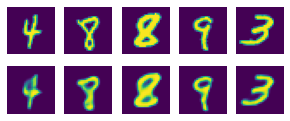

In [6]:
# 컴파일 및 학습을 하는 부분
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam')

autoencoder.fit(X_train, X_train,
                validation_data = (X_test, X_test), 
                epochs = 50, 
                batch_size = 128)

# 학습된 결과를 출력하는 부분
random_test = np.random.randint(X_test.shape[0], size = 5)

# 테스트할 이미지를 랜덤으로 호출
# 앞서 만든 오토 인코더 모델에 넣기
ae_imgs = autoencoder.predict(X_test)

# 출력 이미지 크기 정하기
plt.figure(figsize = (7, 2))

for i, image_idx in enumerate(random_test):

    # 랜덤으로 뽑은 이미지를 차례로 나열
    ax = plt.subplot(2, 7, i + 1)

    # 테스트할 이미지를 먼저 그대로 보여줌
    plt.imshow(X_test[image_idx].reshape(28, 28))
    ax.axis('off')
    ax = plt.subplot(2, 7, 7 + i + 1)

    # 오토인코딩 결과를 다음 열에 입력
    plt.imshow(ae_imgs[image_idx].reshape(28, 28))
    ax.axis('off')

plt.show()